# Disaster Tweets NLP

<img src = "https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-031-48984-6_10/MediaObjects/557046_1_En_10_Fig3_HTML.png">

 
## Problemin Tanımı
Bu proje, **Kaggle NLP with Disaster Tweets** yarışması kapsamında tweetlerin gerçek bir afetten bahsedip bahsetmediğini sınıflandırmayı amaçlar.


# Veri Yükleme


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = '../data'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')


In [2]:
try:
    df_train = pd.read_csv(TRAIN_PATH)
    df_test = pd.read_csv(TEST_PATH)
    print(f'Train Shape: {df_train.shape}')
    print(f'Test Shape: {df_test.shape}')
except FileNotFoundError:
    print('HATA: Veri dosyaları bulunamadı.')
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()


Train Shape: (7613, 5)
Test Shape: (3263, 4)


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
df_train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Veri İnceleme


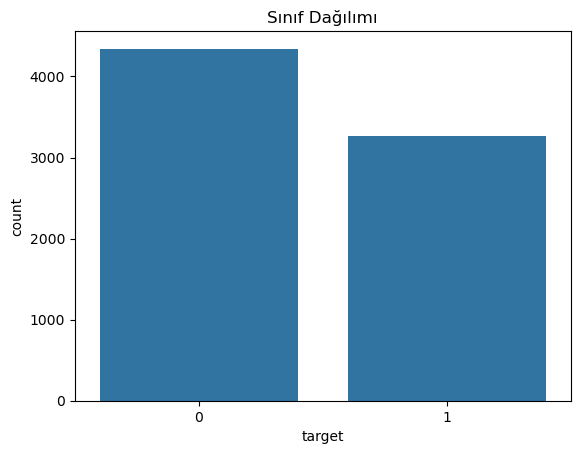

In [6]:
if not df_train.empty:
    sns.countplot(x='target', data=df_train)
    plt.title('Sınıf Dağılımı')
    plt.show()


# Preprocessing


In [7]:
def clean_text(text):
    if not isinstance(text, str): return str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

if not df_train.empty:
    df_train['clean_text'] = df_train['text'].apply(clean_text)
    df_test['clean_text'] = df_test['text'].apply(clean_text)
    print('Cleaned.')


Cleaned.


# Train-Test Split


In [9]:
from sklearn.model_selection import train_test_split
if not df_train.empty:
    X = df_train['clean_text']
    y = df_train['target']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Modeling


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

if not df_train.empty:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', LogisticRegression(random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)
    print(f'Validation F1: {f1_score(y_val, preds):.4f}')
    print(classification_report(y_val, preds))


Validation F1: 0.7696
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.84      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



# Save Model


In [11]:
import joblib
if not df_train.empty:
    os.makedirs('../models', exist_ok=True)
    joblib.dump(pipeline, '../models/best_model.pkl')
    print('Model Saved.')


Model Saved.


# Submission


In [12]:
if not df_test.empty:
    final_preds = pipeline.predict(df_test['clean_text'])
    submission = pd.DataFrame({'id': df_test['id'], 'target': final_preds})
    os.makedirs('../outputs', exist_ok=True)
    submission.to_csv('../outputs/submission.csv', index=False)
    print('Submission Saved.')
    display(submission.head())


Submission Saved.


,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
